In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import numpy as np

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
X=np.load('data_X.npy')
y=np.load('data_y.npy')

In [3]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.25)

In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.2,1.0],
    zoom_range=[0.8,1.2],
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=32)

Using TensorFlow backend.


In [5]:
from keras import models, layers
from keras import Input
from keras.applications import VGG16
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.trainable = False
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
for layer in model.layers:
    layer.trainable=False

x=model.output
x=layers.Flatten()(x)
outputs=Dense(4, activation='softmax')(x)

additional_model=Model(inputs=model.input, outputs=outputs)

additional_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [7]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [8]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='VGG16_참고문헌_1.hdf5', 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True)

In [9]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-3),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [10]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=3, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint])

Epoch 1/3
41/40 [==============================] - 13s 326ms/step - loss: 1.5011 - acc: 0.3481 - auc: 0.5650 - precision: 0.3275 - recall: 0.1899 - f1score: 0.1072 - val_loss: 1.1351 - val_acc: 0.4743 - val_auc: 0.6294 - val_precision: 0.4241 - val_recall: 0.2031 - val_f1score: 0.1284
Epoch 2/3
41/40 [==============================] - 10s 253ms/step - loss: 1.1328 - acc: 0.4868 - auc: 0.6696 - precision: 0.4786 - recall: 0.2191 - f1score: 0.1297 - val_loss: 1.0480 - val_acc: 0.5397 - val_auc: 0.7012 - val_precision: 0.5178 - val_recall: 0.2330 - val_f1score: 0.1375
Epoch 3/3
41/40 [==============================] - 11s 273ms/step - loss: 1.1461 - acc: 0.4860 - auc: 0.7180 - precision: 0.5357 - recall: 0.2465 - f1score: 0.1335 - val_loss: 1.2835 - val_acc: 0.4299 - val_auc: 0.7216 - val_precision: 0.5334 - val_recall: 0.2628 - val_f1score: 0.1289


In [11]:
for layer in additional_model.layers[:11]:
    layer.trainable=False

for layer in additional_model.layers[11:]:
    layer.trainable=True

In [12]:
for layer in additional_model.layers:
    print(layer, layer.trainable)
    
additional_model.summary()

<keras.engine.input_layer.InputLayer object at 0x0000028ECA8DE488> False
<keras.layers.convolutional.Conv2D object at 0x0000028ECA8DF308> False
<keras.layers.convolutional.Conv2D object at 0x0000028ECA8DFF48> False
<keras.layers.pooling.MaxPooling2D object at 0x0000028DAE215F88> False
<keras.layers.convolutional.Conv2D object at 0x0000028DAE210208> False
<keras.layers.convolutional.Conv2D object at 0x0000028DAE217F08> False
<keras.layers.pooling.MaxPooling2D object at 0x0000028DAE21E448> False
<keras.layers.convolutional.Conv2D object at 0x0000028DAE21EF08> False
<keras.layers.convolutional.Conv2D object at 0x0000028DAE224DC8> False
<keras.layers.convolutional.Conv2D object at 0x0000028DAE235388> False
<keras.layers.pooling.MaxPooling2D object at 0x0000028DAE23BB08> False
<keras.layers.convolutional.Conv2D object at 0x0000028DAE23B388> True
<keras.layers.convolutional.Conv2D object at 0x0000028DAE242E48> True
<keras.layers.convolutional.Conv2D object at 0x0000028DAE24B448> True
<keras.

C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [13]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [14]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=10, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint])

Epoch 1/10
41/40 [==============================] - 12s 301ms/step - loss: 1.3555 - acc: 0.3442 - auc_1: 0.6163 - precision_1: 0.4777 - recall_1: 0.0924 - f1score: 0.1088 - val_loss: 1.2953 - val_acc: 0.3645 - val_auc_1: 0.6256 - val_precision_1: 0.5066 - val_recall_1: 0.0539 - val_f1score: 0.1087
Epoch 2/10
41/40 [==============================] - 11s 271ms/step - loss: 1.2425 - acc: 0.4213 - auc_1: 0.6482 - precision_1: 0.5143 - recall_1: 0.0535 - f1score: 0.1174 - val_loss: 1.2376 - val_acc: 0.3598 - val_auc_1: 0.6636 - val_precision_1: 0.5271 - val_recall_1: 0.0629 - val_f1score: 0.1165
Epoch 3/10
41/40 [==============================] - 11s 274ms/step - loss: 1.1442 - acc: 0.4688 - auc_1: 0.6812 - precision_1: 0.5456 - recall_1: 0.0793 - f1score: 0.1281 - val_loss: 1.0527 - val_acc: 0.4883 - val_auc_1: 0.6997 - val_precision_1: 0.5514 - val_recall_1: 0.1048 - val_f1score: 0.1353
Epoch 4/10
41/40 [==============================] - 11s 274ms/step - loss: 1.0337 - acc: 0.5257 - auc_1

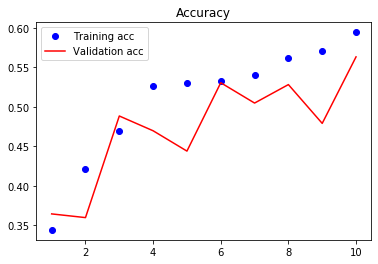

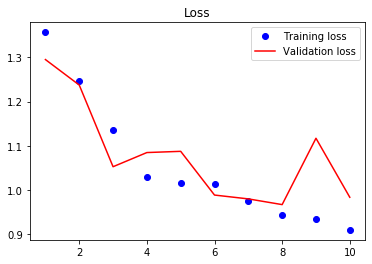

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [16]:
for layer in additional_model.layers:
    layer.trainable=True

In [17]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(name='auc'),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=37, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint])

Epoch 1/37
41/40 [==============================] - 13s 307ms/step - loss: 0.8907 - acc: 0.5974 - auc: 0.8480 - precision_2: 0.6792 - recall_2: 0.4545 - f1score: 0.1551 - val_loss: 0.9421 - val_acc: 0.5701 - val_auc: 0.8552 - val_precision_2: 0.6762 - val_recall_2: 0.4625 - val_f1score: 0.1529
Epoch 2/37
41/40 [==============================] - 11s 272ms/step - loss: 0.8137 - acc: 0.6340 - auc: 0.8575 - precision_2: 0.6779 - recall_2: 0.4751 - f1score: 0.1617 - val_loss: 0.9304 - val_acc: 0.5748 - val_auc: 0.8632 - val_precision_2: 0.6829 - val_recall_2: 0.4921 - val_f1score: 0.1555
Epoch 3/37
41/40 [==============================] - 11s 273ms/step - loss: 0.7974 - acc: 0.6456 - auc: 0.8652 - precision_2: 0.6862 - recall_2: 0.5014 - f1score: 0.1634 - val_loss: 0.9857 - val_acc: 0.5561 - val_auc: 0.8657 - val_precision_2: 0.6848 - val_recall_2: 0.5075 - val_f1score: 0.1538
Epoch 4/37
41/40 [==============================] - 11s 277ms/step - loss: 0.8111 - acc: 0.6340 - auc: 0.8665 - pre

Epoch 29/37
41/40 [==============================] - 11s 274ms/step - loss: 0.6126 - acc: 0.7539 - auc: 0.8909 - precision_2: 0.7051 - recall_2: 0.5845 - f1score: nan - val_loss: 1.0121 - val_acc: 0.5701 - val_auc: 0.8913 - val_precision_2: 0.7059 - val_recall_2: 0.5858 - val_f1score: 0.1592
Epoch 30/37
41/40 [==============================] - 11s 273ms/step - loss: 0.5959 - acc: 0.7516 - auc: 0.8918 - precision_2: 0.7069 - recall_2: 0.5872 - f1score: 0.1853 - val_loss: 1.0338 - val_acc: 0.6028 - val_auc: 0.8921 - val_precision_2: 0.7076 - val_recall_2: 0.5885 - val_f1score: 0.1637
Epoch 31/37
41/40 [==============================] - 12s 290ms/step - loss: 0.5642 - acc: 0.7570 - auc: 0.8927 - precision_2: 0.7084 - recall_2: 0.5898 - f1score: nan - val_loss: 0.9834 - val_acc: 0.6098 - val_auc: 0.8932 - val_precision_2: 0.7092 - val_recall_2: 0.5912 - val_f1score: 0.1639
Epoch 32/37
41/40 [==============================] - 11s 259ms/step - loss: 0.5561 - acc: 0.7702 - auc: 0.8937 - preci

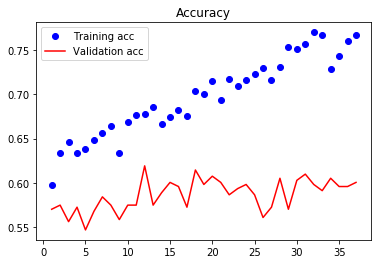

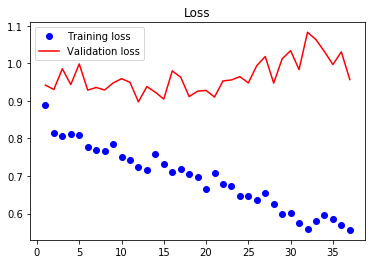

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [19]:
X_test=np.load('X_test.npy')
y_test=np.load('y_test.npy')

In [20]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

428/428 [==============================] - 1s 3ms/step
loss: 0.957, accuracy: 0.600, auc: 0.898, precision: 0.716, recall: 0.603, f1score: 0.162


In [21]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_test, y_test, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

704/704 [==============================] - 2s 3ms/step
loss: 96705.182, accuracy: 0.263, auc: 0.894, precision: 0.713, recall: 0.602, f1score: nan


In [1]:
additional_model.save('VGG16_참고문헌.h5')

NameError: name 'additional_model' is not defined

In [23]:
from sklearn.metrics import roc_auc_score

y_pred = additional_model.predict(X_val)
roc_auc_score(y_val, y_pred)

0.8588260522679616